In [1]:
from IPython.display import FileLink
import pandas as pd
import pandas.rpy.common as com
import brewer2mpl
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from matplotlib import gridspec
from matplotlib import collections
from numpy import nan, min, array
import itertools
from mpltools import style
style.use("ggplot")
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
%%R
library(phyloseq)
library(plyr); library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following object is masked from ‘package:stats’:

    filter

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
%%R
physeq = import_biom("data/otu_table_wtax.biom", "data/otusn.tree")
sample.data = import_qiime_sample_data("data/ABCD_combined_reads_mapper.tsv")
physeq = merge_phyloseq(physeq,sample.data)
physeq.md = sample_data(physeq)
physeq.SS = prune_samples((physeq.md$Treatment %in% c("12CCPS","13CCPS","13CCSS", "12CCSS"))& 
                         (physeq.md$Day == 30)&
                          !(row.names(physeq.md) %in% grep("bulk", row.names(physeq.md), value=TRUE)), physeq)
physeq.SS

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6236 taxa and 80 samples ]
sample_data() Sample Data:       [ 80 samples by 7 sample variables ]
tax_table()   Taxonomy Table:    [ 6236 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 6236 tips and 6235 internal nodes ]


In [4]:
matplotlib.rcParams["axes.facecolor"] = "white"
matplotlib.rcParams["axes.edgecolor"] = "#151515"
matplotlib.rcParams["grid.color"] = "#959595"
matplotlib.rcParams["grid.alpha"] = "0.50"
matplotlib.rcParams["font.size"] = 7.5

def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R df_tree = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$label = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R df_tree = join(df_tree, tax, type = "left", by = "label")
    tree_df = com.load_data("df_tree")
    return tree_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

#def add_tree_info(tip_df, l2fc_df):
#    leaf_nodes = tip_df[tip_df["is.leaf"]==True]["node"].tolist()
#    criterion = tip_df["node"].map(lambda x: x in leaf_nodes)
#    l2fc_df = l2fc_df.merge(tip_df[criterion & (tip_df["dir"]=="up") & (tip_df["type"] == "line")][["y","label"]], 
#                            left_on="OTU", 
#                            right_on="label")
#    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict[nan] = "#505050"
    return color_dict

def get_responders(l2fc_df, Treatment):
    min_padj = l2fc_df[["OTU","padj","Treatment"]].groupby(["Treatment","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[Treatment]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    tip_df = get_tree_df(physeq_str, otus.tolist())
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
    
    Days = map(str,[30])
    scaleFactor = 0.125
    
    PS_rspdrs = get_responders(l2fc_df, "13CCPS")
    SS_rspdrs = get_responders(l2fc_df, "13CCSS")

    df_pivot = l2fc_df.pivot_table(rows=["y"], cols=["Treatment","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 20]))

    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[6,2.25,1.0,1.0])

    fig = plt.figure()
    fig.set_size_inches((5,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap

    tdf_lines = tip_df[tip_df["type"] == "line"]
    leaf_nodes = tip_df[tip_df["is.leaf"]==True]["node"].tolist()
    criterion1 = tip_df["node"].map(lambda x: x in leaf_nodes)
    tdf_tip_locs = tip_df[criterion1 & (tip_df["dir"]=="up") & (tip_df["type"] == "line")]
    start = zip(tdf_lines.x, tdf_lines.y - 1)
    end = zip(tdf_lines.xend, tdf_lines.yend - 1)
    lines = zip(start, end)
    lc = mpl.collections.LineCollection(segments=lines, color = "k")
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(lc)
    ax1.autoscale()
    ax1.hlines(y = tdf_tip_locs.y - 1, 
               xmin = tdf_tip_locs.x, 
               xmax = ax1.get_xlim()[1],
               colors = [tax_colors[v] for v in tdf_tip_locs[color_rank]],
               lw = lw_tax)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    ax1.set_xlim([tdf_lines.x.min(), tdf_lines.xend.max()*1.02])

    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tdf_tip_locs["label"].map(lambda x: x in PS_rspdrs)
    criterion3 = tdf_tip_locs["label"].map(lambda x: x in SS_rspdrs)
    PS_rspndrs_tips = tdf_tip_locs[criterion2]
    SS_rspndrs_tips = tdf_tip_locs[criterion3]
    ax2.scatter(x = [1 for i in PS_rspndrs_tips.y], 
                y = PS_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in SS_rspndrs_tips.y], 
                y = SS_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["13CCPS","13CCSS"], rotation = 90, ha = "left", size = 8)
    ax2.set_yticks([])
    
    vmin = l2fc_df["log2FoldChange"].quantile(0.05)
    vmax = l2fc_df["log2FoldChange"].quantile(0.95)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks(range(len(Days[1:])))
    ax3.set_xticklabels(Days[1:])
    ax3.set_yticklabels([])
    ax3.set_title("13CCPS", fontsize=7)
    #ax3.set_xlabel("Day")
    df = df_pivot["13CCPS"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax1)
    #ax4.set_xticks(range(len(Days)))
    ax4.set_xticklabels(Days)
    ax4.set_yticklabels([])
    ax4.set_title("13CCSS", fontsize=7)
    #ax4.set_xlabel("Day")
    df = df_pivot["13CCSS"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"log$_{2}$ Fold Change")

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i]) for i in tdf_tip_locs.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tdf_tip_locs.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':18,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

In [5]:
def get_l2fc_df(df_fp, taxon, rank):
    df = pd.read_csv(df_fp, sep=",")
    df_subset = df[df[rank]==taxon]
    return df_subset, df_subset["OTU"]

def get_tree_df(physeq_str, OTUs):
    subset_fn_str = "prune_taxa(OTUs, %s)" %physeq_str
    %Rpush subset_fn_str
    %Rpush OTUs
    %R OTUs = as.character(OTUs)
    %R ps = eval(parse(text=subset_fn_str))
    %R tree_dfs = phyloseq:::tree_layout(phy_tree(ps), ladderize="right")
    %R tax = data.frame(tax_table(ps), stringsAsFactors = FALSE)
    %R tax$OTU = rownames(tax)
    %R tax[is.na(tax)] <- 'unassigned'
    %R edge_df = left_join(data.frame(tree_dfs$edgeDT), tax)
    %R edge_df$OTU = factor(edge_df$OTU)
    %R vert_df = data.frame(tree_dfs$vertDT)
    edge_df = com.load_data("edge_df")
    vert_df = com.load_data("vert_df")
    return edge_df, vert_df

def add_tree_info(tip_df, l2fc_df):
    l2fc_df = l2fc_df.merge(tip_df[["y","OTU"]], 
                            left_on="OTU", 
                            right_on="OTU")
    return l2fc_df

def get_tax_colordict(tip_df, color_rank):
    cats = set(tip_df[color_rank].dropna())
    c_list = []
    for m in ["Set3", "Dark2", "Accent", "Set1"]:
        colors = brewer2mpl.get_map(m, "qualitative", 8).hex_colors
        [c_list.append(c) for c in colors]
    color_dict = dict(itertools.izip(cats, itertools.cycle(c_list)))
    color_dict["unassigned"] = "#505050"
    return color_dict

def get_responders(l2fc_df, treatment):
    min_padj = l2fc_df[["OTU","padj","Treatment"]].groupby(["Treatment","OTU"]).min()
    t = min_padj["padj"]
    tmp = t[treatment]
    rsp = tmp[tmp<0.10].index.tolist()
    return rsp
    
def make_tree_fig(taxon, taxon_rank, color_rank, l2fc_fp, physeq_str, lw_tax = 3, leg_spacing = 0.25, 
                  save_fn = None, pt_size = 50):
    l2fc_df, otus = get_l2fc_df(l2fc_fp, taxon, taxon_rank)
    edge_df, vert_df = get_tree_df(physeq_str, otus.tolist())
    tip_df = edge_df[edge_df["OTU"].notnull()]
    l2fc_df = add_tree_info(tip_df, l2fc_df)
    tax_colors = get_tax_colordict(tip_df, color_rank)
    
    days = map(str,[3,7,14,30])
    scaleFactor = 0.125
    
    cell_rspdrs = get_responders(l2fc_df, "13CCPS")
    xyl_rspdrs = get_responders(l2fc_df, "13CCSS")

    df_pivot = l2fc_df.pivot_table(rows=["y"], cols=["Treatment","Day"], values="log2FoldChange")
    figHeight = min(array([df_pivot.shape[0]*scaleFactor, 30]))

    gs = gridspec.GridSpec(nrows=1, ncols=4, width_ratios=[6,1.75,1,1])

    fig = plt.figure()
    fig.set_size_inches((5,figHeight))
    #fig.set_size_inches((8,20))
    fig.subplots_adjust(wspace=0.05)

    cm = brewer2mpl.get_map('RdYlBu', 'diverging', 5, reverse=True).mpl_colormap

    edge_segments = edge_df.apply(lambda row: [(row["xleft"], row["y"]-1), (row["xright"], row["y"]-1)], axis = 1).values
    edge_collection = collections.LineCollection(segments = edge_segments, color="k", linewidths = 1.5)
    
    vert_segments = vert_df.apply(lambda row: [(row["x"], row["vmin"]-1), (row["x"], row["vmax"]-1)], axis = 1).values
    vert_collection = collections.LineCollection(segments = vert_segments, color="k", linewidths = 1.5)

    max_right = tip_df["xright"].max() * 1.05
    buff = 0.025
    verts = tip_df.apply(lambda row: [(row["xright"] + buff, row["y"] - 1.5), 
                                      (row["xright"] + buff, row["y"] - 0.5),
                                      (max_right, row["y"] - 0.5), 
                                      (max_right, row["y"] - 1.5)], axis = 1).values
    rect_collection = collections.PolyCollection(verts, 
                                             facecolors = tip_df.apply(lambda x: tax_colors[x[color_rank]], axis = 1),
                                             alpha = 0.75)
    
    ax1 = fig.add_subplot(gs[0])
    ax1.add_collection(edge_collection)
    ax1.add_collection(vert_collection)
    ax1.add_collection(rect_collection)
    ax1.set_xlim(edge_df["xleft"].min() - edge_df["xright"].max() * 0.05, edge_df["xright"].max() * 1.05)
    ax1.set_ylim(edge_df["y"].min() - edge_df["y"].max() * 0.05, edge_df["y"].max() * 1.05)
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.set_frame_on(False)
    ax1.grid(False)
    ax1.set_title(taxon, fontdict = {"fontsize": 14})

    ax2 = fig.add_subplot(gs[1], sharey = ax1)
    criterion2 = tip_df["OTU"].map(lambda x: x in cell_rspdrs)
    criterion3 = tip_df["OTU"].map(lambda x: x in xyl_rspdrs)
    cell_rspndrs_tips = tip_df[criterion2]
    xyl_rspndrs_tips = tip_df[criterion3]
    ax2.scatter(x = [1 for i in cell_rspndrs_tips.y], 
                y = cell_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#377eb8")
    ax2.scatter(x = [2 for i in xyl_rspndrs_tips.y], 
                y = xyl_rspndrs_tips.y -1, 
                s = pt_size, zorder = 100, color = "#4daf4a")
    ax2.set_frame_on(False)
    ax2.set_xlim([0,3])
    ax2.set_xticks([1,2])
    ax2.set_xticklabels(["Complex","Simple"], rotation = 90, size = 12)
    ax2.set_yticks([])
    
    vmin = l2fc_df["log2FoldChange"].quantile(0.025)
    vmax = l2fc_df["log2FoldChange"].quantile(0.975)

    ax3 = fig.add_subplot(gs[2], sharey = ax1)
    ax3.set_xticks([])
    #ax3.set_xticklabels(days[1:])
    ax3.set_yticklabels([])
    ax3.set_title("Complex", rotation = 45, va = 'bottom', ha = 'left')
    #ax3.set_xlabel("Day")
    df = df_pivot["13CCPS"]
    im = ax3.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax3.grid(False)

    ax4 = fig.add_subplot(gs[3], sharey = ax1)
    ax4.set_xticks([])
    ax4.set_xticklabels(days)
    ax4.set_yticklabels([])
    ax4.set_title("Simple", rotation = 45, va = 'bottom', ha = 'left')
    #ax4.set_xlabel("Day")
    df = df_pivot["13CCSS"]
    ax4.imshow(df.as_matrix(), interpolation="nearest", aspect="auto", cmap=cm, vmax=vmax, vmin=vmin)
    ax4.grid(False)

    box = ax4.get_position()
    cax = fig.add_axes([box.xmax + 0.05, box.ymin + 2 * box.height / 3, 0.02, box.height / 3])
    cb = fig.colorbar(im, cax = cax)
    cb.set_label(r"Log$_{2}$ Fold Change", size = 12)

    proxy_artists = [plt.Rectangle((0,0),1,1,fc=tax_colors[i],alpha=0.75) 
                     for i in tip_df.sort("y")[color_rank].unique().tolist()]
    leg = ax1.legend(proxy_artists, 
                     tip_df.sort("y")[color_rank].unique().tolist(),
                     bbox_to_anchor = (0, -leg_spacing),
                     loc = 2, ncol = 2,
                     prop={'size':12,'style':"italic"}, labelspacing = 0.2)
    leg.set_frame_on(False)
    
    if save_fn:
        fig.savefig(save_fn, bbox_extra_artists=(leg, cax), bbox_inches='tight')

Joining by: "OTU"


/opt/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'cols' keyword is deprecated, use 'columns' instead
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python2.7/site-packages/pandas/util/decorators.py:81: FutureWarning: the 'rows' keyword is deprecated, use 'index' instead
  warnings.warn(msg, FutureWarning)


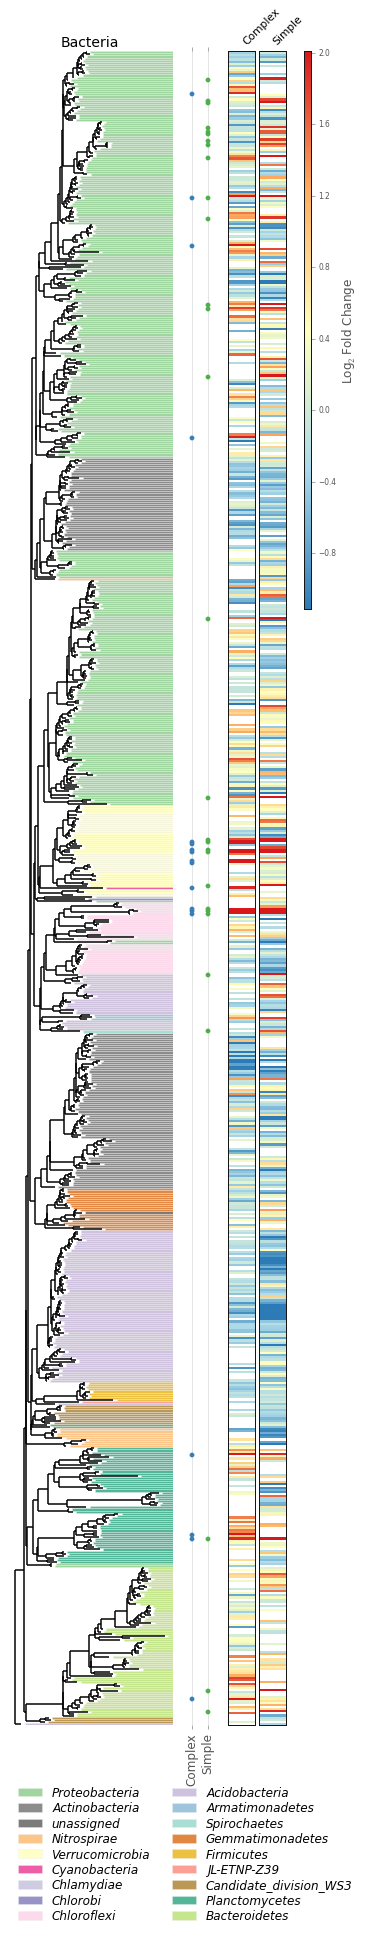

In [6]:
make_tree_fig("Bacteria", "Rank1", "Rank2", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/bacteria_tree.pdf", lw_tax = 1, leg_spacing = 0.03,
              pt_size = 18)

In [7]:
FileLink("figs/bacteria_tree.pdf")

/home/ashley/single_substrate/figs/bacteria_tree.pdf

Joining by: "OTU"


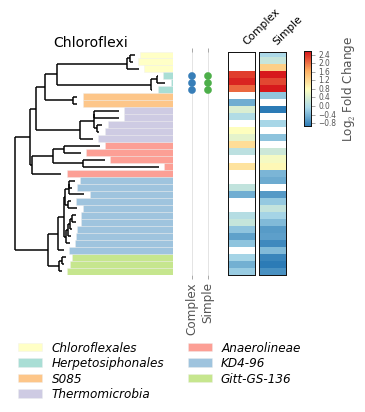

In [8]:
make_tree_fig("Chloroflexi", "Rank2", "Rank3", "data/l2fc_table.csv", "physeq.SS", 
              save_fn="figs/chloroflexi_tree.pdf")

In [9]:
FileLink("figs/chloroflexi_tree.pdf")

/home/ashley/single_substrate/figs/chloroflexi_tree.pdf

Joining by: "OTU"


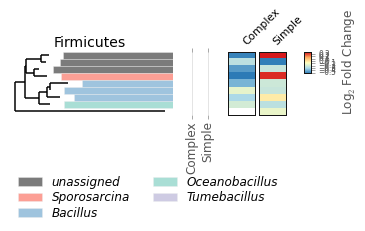

In [10]:
make_tree_fig("Firmicutes", "Rank2", "Rank6", "data/l2fc_table.csv", "physeq.SS",
              save_fn = "figs/firmicutes_tree.pdf", leg_spacing = 0.8)

In [11]:
FileLink("figs/firmicutes_tree.pdf")

/home/ashley/single_substrate/figs/firmicutes_tree.pdf

Joining by: "OTU"


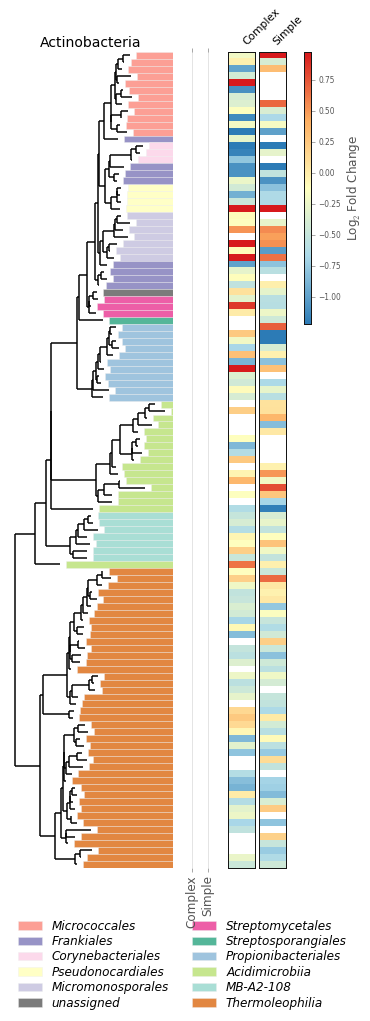

In [12]:
make_tree_fig("Actinobacteria", "Rank2", "Rank3", "data/l2fc_table.csv", "physeq.SS",
              save_fn = "figs/actinobacteria_tree.pdf", leg_spacing = 0.05)

In [13]:
FileLink("figs/actinobacteria_tree.pdf")

/home/ashley/single_substrate/figs/actinobacteria_tree.pdf

Joining by: "OTU"


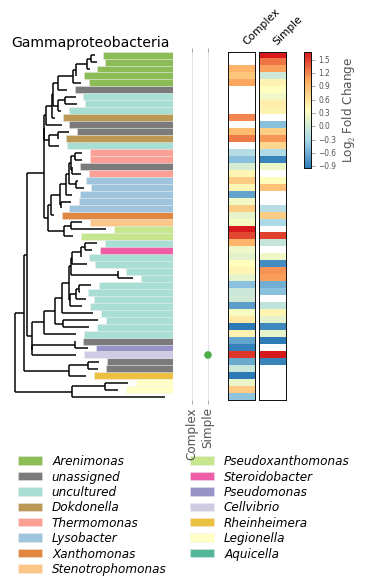

In [14]:
make_tree_fig("Gammaproteobacteria", "Rank3", "Rank6", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/gammaproteo_tree.pdf", leg_spacing = 0.125)

In [15]:
FileLink("figs/gammaproteo_tree.pdf")

/home/ashley/single_substrate/figs/gammaproteo_tree.pdf

Joining by: "OTU"


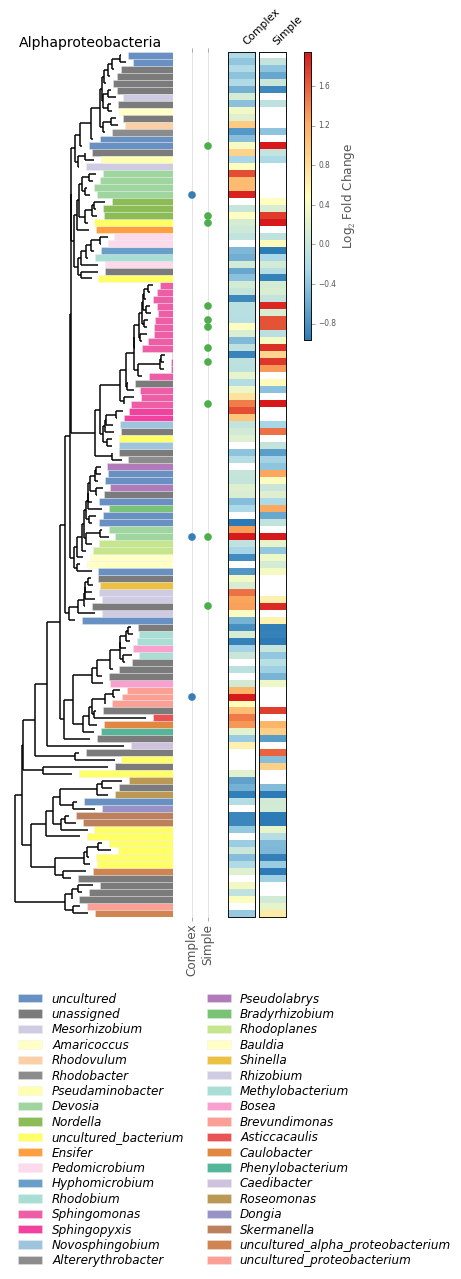

In [16]:
make_tree_fig("Alphaproteobacteria", "Rank3", "Rank6", "data/l2fc_table.csv", "physeq.SS", 
               save_fn = "figs/alphaproteo_tree.pdf", leg_spacing = 0.075)

In [17]:
FileLink("figs/alphaproteo_tree.pdf")

/home/ashley/single_substrate/figs/alphaproteo_tree.pdf

Joining by: "OTU"


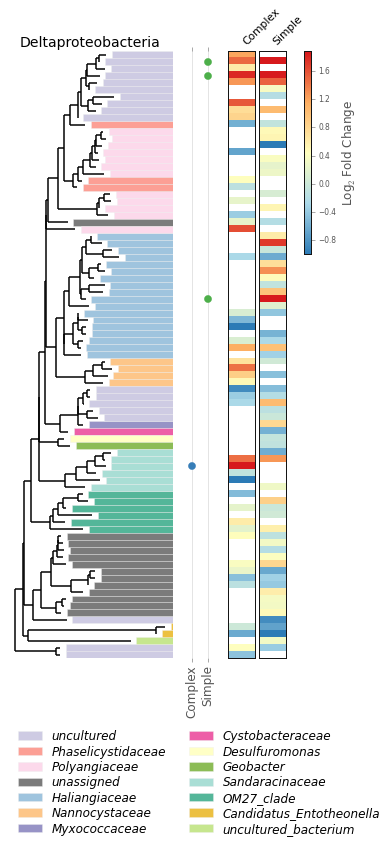

In [18]:
make_tree_fig("Deltaproteobacteria", "Rank3", "Rank6", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/deltaproteo_tree.pdf", leg_spacing = 0.1)

In [19]:
FileLink("figs/deltaproteo_tree.pdf")

/home/ashley/single_substrate/figs/deltaproteo_tree.pdf

Joining by: "OTU"


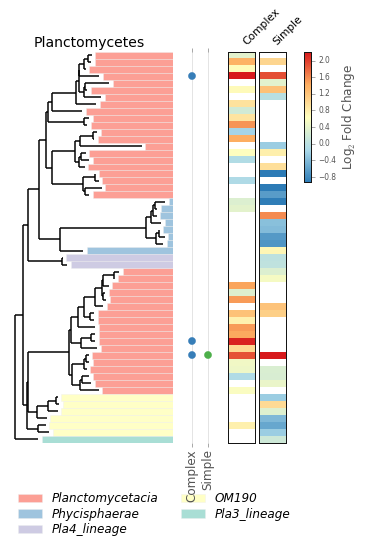

In [20]:
make_tree_fig("Planctomycetes", "Rank2", "Rank3", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/planctomycetes_tree.pdf", leg_spacing = 0.1)

In [21]:
FileLink("figs/planctomycetes_tree.pdf")

/home/ashley/single_substrate/figs/planctomycetes_tree.pdf

Joining by: "OTU"


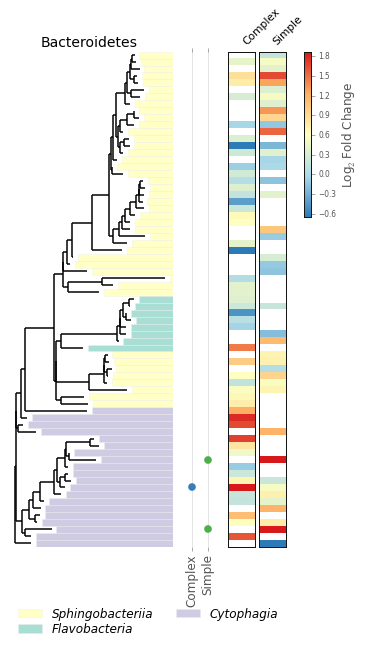

In [22]:
make_tree_fig("Bacteroidetes", "Rank2", "Rank3", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/bacteroidetes_tree.pdf", leg_spacing = 0.1)

In [23]:
FileLink("figs/bacteroidetes_tree.pdf")

/home/ashley/single_substrate/figs/bacteroidetes_tree.pdf

Joining by: "OTU"


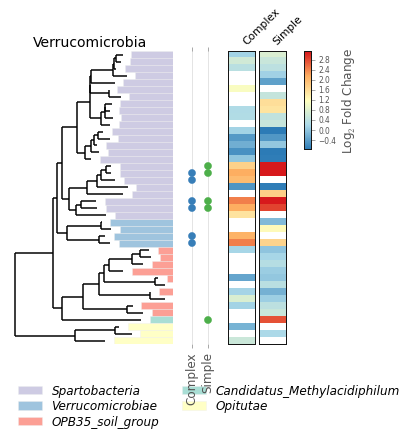

In [24]:
make_tree_fig("Verrucomicrobia", "Rank2", "Rank3", "data/l2fc_table.csv", "physeq.SS", 
              save_fn = "figs/verrucomicrobia_tree.pdf", leg_spacing = 0.1)

In [25]:
FileLink("figs/verrucomicrobia_tree.pdf")

/home/ashley/single_substrate/figs/verrucomicrobia_tree.pdf